In [40]:
from torch_snippets import *
from torchvision import transforms as T
from torch.nn import functional as F
from torchvision.models import vgg19
import torch.optim as optim
import torch
import torch.nn as nn


device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [41]:
preprocess = T.Compose([
    T.ToTensor(),
    T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    T.Lambda(lambda x: x.mul_(255))
])

postprocess = T.Compose([
    T.Lambda(lambda x: x.mul_(1/255)),
    T.Normalize(mean=[-0.485/0.229, -0.456/0.224, -0.406/0.225], std=[1/0.229, 1/0.224, 1/0.225]),
])

In [42]:
# calcula a matriz de gram para capturar a correlação entre os canais
class GranMatrix(nn.Module):
    def forward(self, x):
        b, c, h, w = x.shape
        feat = x.view(b, c, h*w)
        G = feat@feat.transpose(1, 2)
        G.div_(h*w)
        return G

# calcula a mse entre a matriz de gram do input e do target
class GramMSELoss(nn.Module):
    def forward(self, input, target):
        out = F.mse_loss(GranMatrix()(input), target)
        return out

# versão modificada da vgg19 para extrair características intermediárias
class vgg19_modified(nn.Module):
    def __init__(self):
        super().__init__()
        features = list(vgg19(pretrained = True).features)
        self.features = nn.ModuleList(features).eval()

    def forward(self, x, layers = []):
        order = np.argsort(layers)
        _results, results = [], []

        for ix, model in enumerate(self.features):
            x = model(x)
            if ix in layers:
                _results.append(x)
        for o in order:
            results.append(_results[o])

        return results if layers is not [] else x


In [43]:
vgg = vgg19_modified().to(device)

c:\Users\kaiqu\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\kaiqu\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [44]:
# %wget https://easydrawingguides.com/wp-content/uploads/2016/10/how-to-draw-an-elephant-featured-image-1200-1024x822.png
# %wget https://www.neh.gov/sites/default/files/2022-09/Fall_2022_web-images_Picasso_32.jpeg

In [45]:
imgs = [Image.open(path).resize((512, 512)).convert('RGB') for path in ['how-to-draw-an-elephant-featured-image-1200-1024x822.png', 'Picasso.jpg']]
style_image, content_image = [preprocess(img).to(device)[None] for img in imgs]

In [46]:
opt_img = content_image.data.clone()
opt_img.requires_grad = True

In [47]:
style_layers = [0, 5, 10, 19, 28]
content_layers = [21]
loss_layers = style_layers + content_layers

In [48]:
loss_fns = [GramMSELoss()] * len(style_layers) + [nn.MSELoss()] * len(content_layers)
loss_fns = [loss_fn.to(device) for loss_fn in loss_fns]

In [49]:
style_weights = [1000/n**2 for n in [64, 128, 256, 512, 512]]
content_weight = [1] # tem que ser em lista mesmo
weights = style_weights + content_weight

In [50]:
style_targets = [GranMatrix()(A).detach() for A in vgg(style_image, style_layers)]
content_targets = [A.detach() for A in vgg(content_image, content_layers)]
targets = style_targets + content_targets

In [51]:
max_iters = 500
optimizer = optim.LBFGS([opt_img])


In [52]:
import matplotlib.pyplot as plt
%matplotlib inline

iters = 0
loss_record = []

while iters < max_iters:
    def closure():
        global iters
        iters += 1
        optimizer.zero_grad()
        out = vgg(opt_img, loss_layers)
        layer_losses = [weights[a] * loss_fns[a](A, targets[a]) for a, A in enumerate(out)]
        loss = sum(layer_losses)
        loss.backward()
        loss_record.append(loss.item())

        return loss
    optimizer.step(closure)

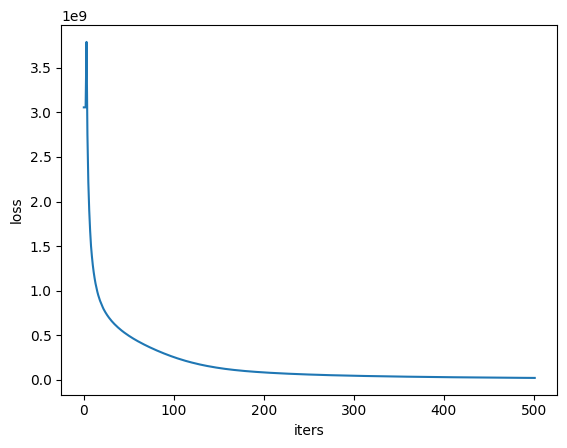

In [53]:
plt.plot(loss_record)
plt.xlabel('iters')
plt.ylabel('loss')
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.4642979..2.1906092].


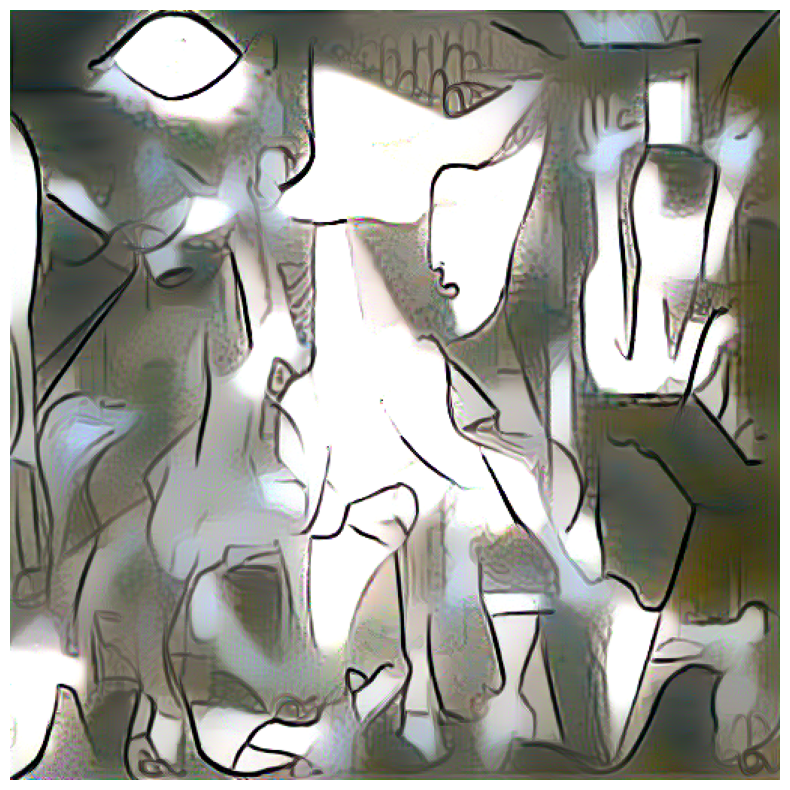

In [54]:
with torch.no_grad():
    out_img = postprocess(opt_img[0]).permute(1, 2, 0)
show(out_img)